### Cab-Driver Agent

In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [0]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [0]:
def tracked_states_init():
    state_action_pair = [((2, 18, 0), (0, 0)),
                         ((4, 21, 5), (1, 3)),
                         ((4, 21, 0), (0, 0)),
                         ((1, 9, 1), (0, 0)),
                         ((4, 0, 2), (3, 2)),
                         ((0, 6, 0), (4, 1)),
                         ((3, 0, 3), (0, 0)),
                         ((1, 10, 0), (3, 1)),
                         ((1, 0, 0), (1, 2)),
                         ((4, 4, 4), (4, 1))]
    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = dict()
        tracked_states[state][action] = list()

In [0]:
def update_tracked_states():
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1,36)
        q_predict = agent.model.predict(encoded_state)

        for action in tracked_states[state].keys():
            for index, a in enumerate(env.action_space):
                if action == a:
                    action_index = index
                    break
                    
            q_value = q_predict[0][action_index]
            tracked_states[state][action].append(q_value)

In [0]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [0]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01     
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        self.epsilon = 1
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state):
        """Choose a action for a given state based on epsilon greedy strategy"""
        # calculation of decay factor for a given episode is done after each episode
        
        random_value = np.random.rand()
        
        possible_requests_index, actions = env.requests(state)
        
        if random_value > self.epsilon:
            # exploitation
            state_encod = np.array(env.state_encod_arch1(state)).reshape(1,m+t+d)
            predicted_q_values = self.model.predict(state_encod)
            filter_q_values = [predicted_q_values[0][i] for i in possible_requests_index]
            index_max_q_value = np.argmax(np.array(filter_q_values))
            selected_action = actions[index_max_q_value]
        else:
            # exploration
            selected_action = random.choice(actions)
        
        
        for i, action in enumerate(env.action_space):
            if selected_action == action:
                selected_action_index = i
                break
        
        return selected_action_index, selected_action


    def append_sample(self, state, action, reward, next_state, is_terminal):
        self.memory.append((state, action, reward, next_state, is_terminal))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, is_terminal = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal = mini_batch[i]
                
                state_encod = env.state_encod_arch1(state)
                update_input[i] = state_encod
                
                next_state_encod = env.state_encod_arch1(next_state)
                update_output[i] = next_state_encod
                
                actions.append(action)
                rewards.append(reward)
                is_terminal.append(terminal)
                
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_q_value = self.model.predict(update_output)

            # 3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if is_terminal[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_q_value[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save(self, name):
        self.model.save(name)

In [0]:
Episodes = 15000
#Episodes = 10

max_total_time_per_episode = 30 * 24
m, t, d = 5, 24, 7
state_size = m + t + d

action_size = m * (m-1) + 1

# Call the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)

# useful metric for tracking
rewards_per_episode = []
no_of_rides_per_episode = []
total_time_per_episode = []
epsilon = []

In [9]:
tracked_states = dict()
tracked_states_init()
tracked_states

{(0, 6, 0): {(4, 1): []},
 (1, 0, 0): {(1, 2): []},
 (1, 9, 1): {(0, 0): []},
 (1, 10, 0): {(3, 1): []},
 (2, 18, 0): {(0, 0): []},
 (3, 0, 3): {(0, 0): []},
 (4, 0, 2): {(3, 2): []},
 (4, 4, 4): {(4, 1): []},
 (4, 21, 0): {(0, 0): []},
 (4, 21, 5): {(1, 3): []}}

### DQN block

In [10]:
start_time = time.time()

for episode in range(Episodes):

    # Call the environment
    env = CabDriver()
    action_space, state_space, state = env.reset()

    terminal_state = False
    total_time = 0
    total_reward = 0
    no_of_rides = 0
    
    while terminal_state == False:
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action_index, action = agent.get_action(state)
        
        # 2. Evaluate your reward and next state
        next_state, reward, duration = env.next_state_func(state, action, Time_matrix)
        total_time += duration
        total_reward += reward
        
        if total_time >= max_total_time_per_episode:
            terminal_state = True
        
        # 3. Append the experience to the memory
        # print("Episode:{}, State:{}, Action:{}, Reward:{}, NextState:{}, Time:{}".format(episode, state, action, total_reward, next_state, total_time))
        agent.append_sample(state, action_index, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        state = next_state
        no_of_rides += 1
        
    # 5. Keep a track of rewards, Q-values, loss
    rewards_per_episode.append(total_reward)
    no_of_rides_per_episode.append(no_of_rides)
    total_time_per_episode.append(total_time)
    
    # decay in epsilon after each episode
    agent.epsilon = (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay*episode)
    epsilon.append(agent.epsilon)
    
    update_tracked_states()
    
    if episode % 200 == 0:
        print("Episode:{} Reward:{} Rides:{} Duration of Episode:{}" \
              .format(episode, total_reward, no_of_rides, total_time))
    
    if episode % 1000 == 0:
        agent.save(name="model_weight.pkl")

agent.save(name="model_weight.pkl")
elapsed_time = time.time() - start_time
print("Elapsed time :", elapsed_time)

Episode:0 Reward:-159 Rides:139 Duration of Episode:723
Episode:200 Reward:-55 Rides:140 Duration of Episode:722
Episode:400 Reward:-43 Rides:137 Duration of Episode:734
Episode:600 Reward:-147 Rides:137 Duration of Episode:726
Episode:800 Reward:145 Rides:129 Duration of Episode:727
Episode:1000 Reward:11 Rides:133 Duration of Episode:725
Episode:1200 Reward:166 Rides:129 Duration of Episode:721
Episode:1400 Reward:346 Rides:125 Duration of Episode:721
Episode:1600 Reward:513 Rides:131 Duration of Episode:720
Episode:1800 Reward:316 Rides:135 Duration of Episode:727
Episode:2000 Reward:459 Rides:148 Duration of Episode:729
Episode:2200 Reward:651 Rides:147 Duration of Episode:723
Episode:2400 Reward:1251 Rides:142 Duration of Episode:720
Episode:2600 Reward:540 Rides:157 Duration of Episode:720
Episode:2800 Reward:713 Rides:132 Duration of Episode:725
Episode:3000 Reward:737 Rides:139 Duration of Episode:722
Episode:3200 Reward:954 Rides:147 Duration of Episode:720
Episode:3400 Reward

### Tracking Convergence

In [11]:
for state in tracked_states.keys():
    for action in tracked_states[state].keys():
        q_values_track_count = len(list(filter(lambda x: x!= 0, tracked_states[state][action])))
        print('state:{} action:{} count:{}'.format(state, action, q_values_track_count))

state:(2, 18, 0) action:(0, 0) count:13653
state:(4, 21, 5) action:(1, 3) count:15000
state:(4, 21, 0) action:(0, 0) count:13653
state:(1, 9, 1) action:(0, 0) count:13653
state:(4, 0, 2) action:(3, 2) count:14822
state:(0, 6, 0) action:(4, 1) count:15000
state:(3, 0, 3) action:(0, 0) count:13653
state:(1, 10, 0) action:(3, 1) count:15000
state:(1, 0, 0) action:(1, 2) count:14956
state:(4, 4, 4) action:(4, 1) count:15000


In [0]:
tracked_states_plotting = [((4, 21, 5), (1, 3)),
                         ((4, 0, 2), (3, 2)),
                         ((0, 6, 0), (4, 1)),
                         ((1, 10, 0), (3, 1))]

In [0]:
def convergence_graph_plot(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {} - Action : {}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [0]:
def log_convergence_graph_plot(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {} - Action : {}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

<Figure size 1440x1080 with 0 Axes>

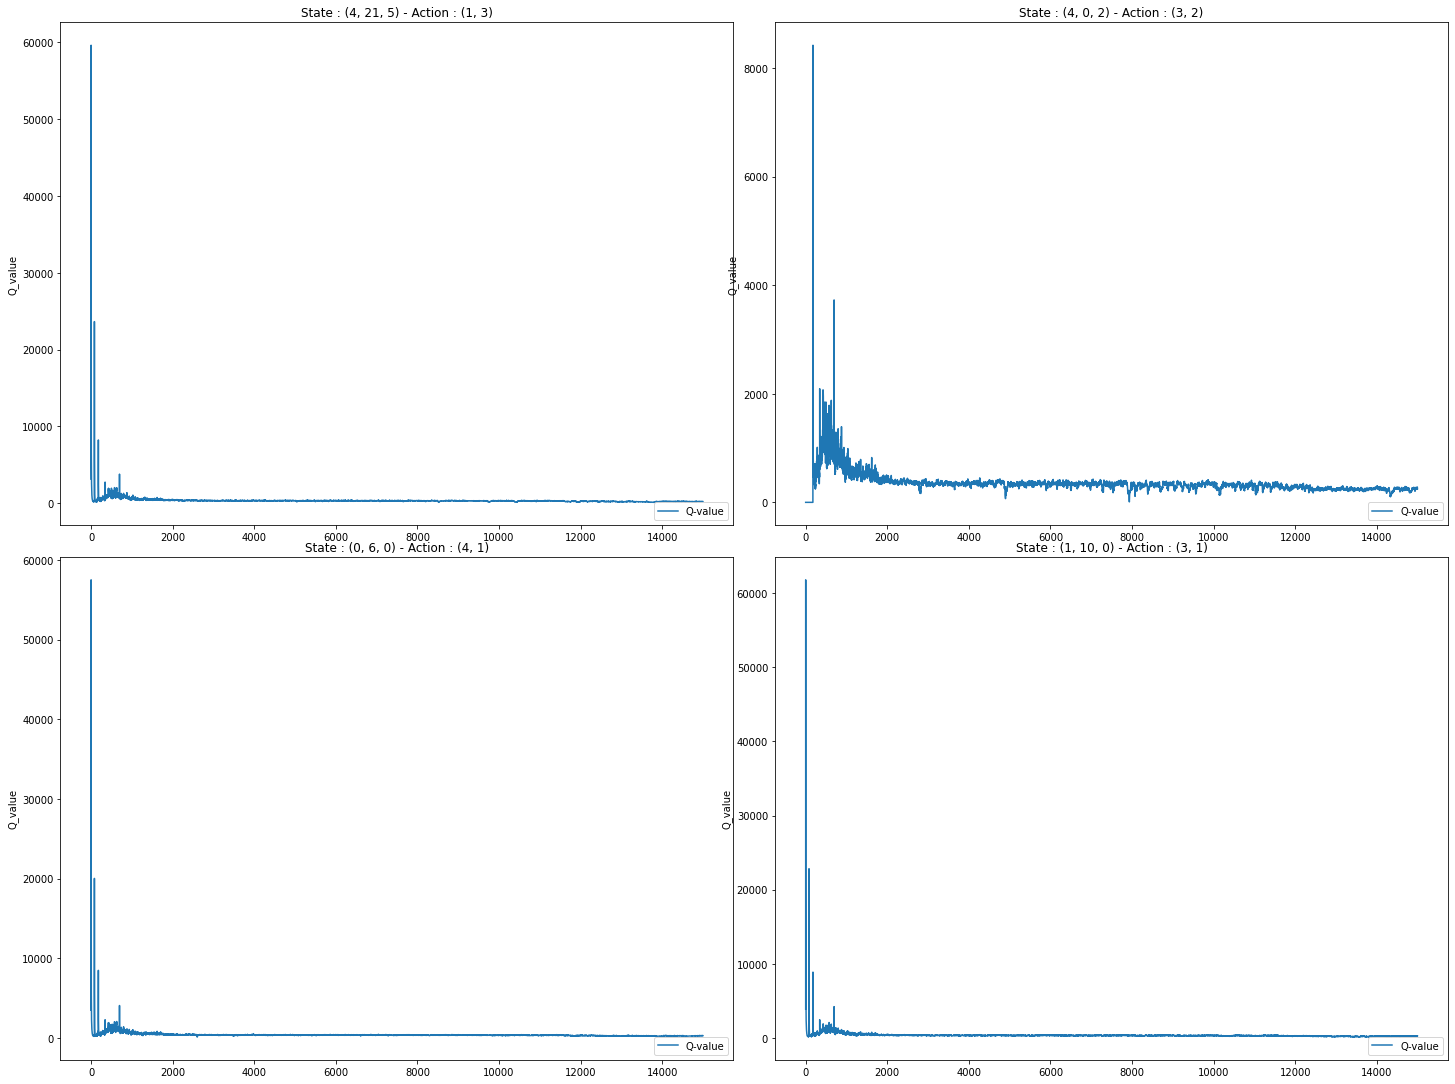

In [15]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        convergence_graph_plot(state, action)
        i +=1

plt.show()

<Figure size 1440x1080 with 0 Axes>

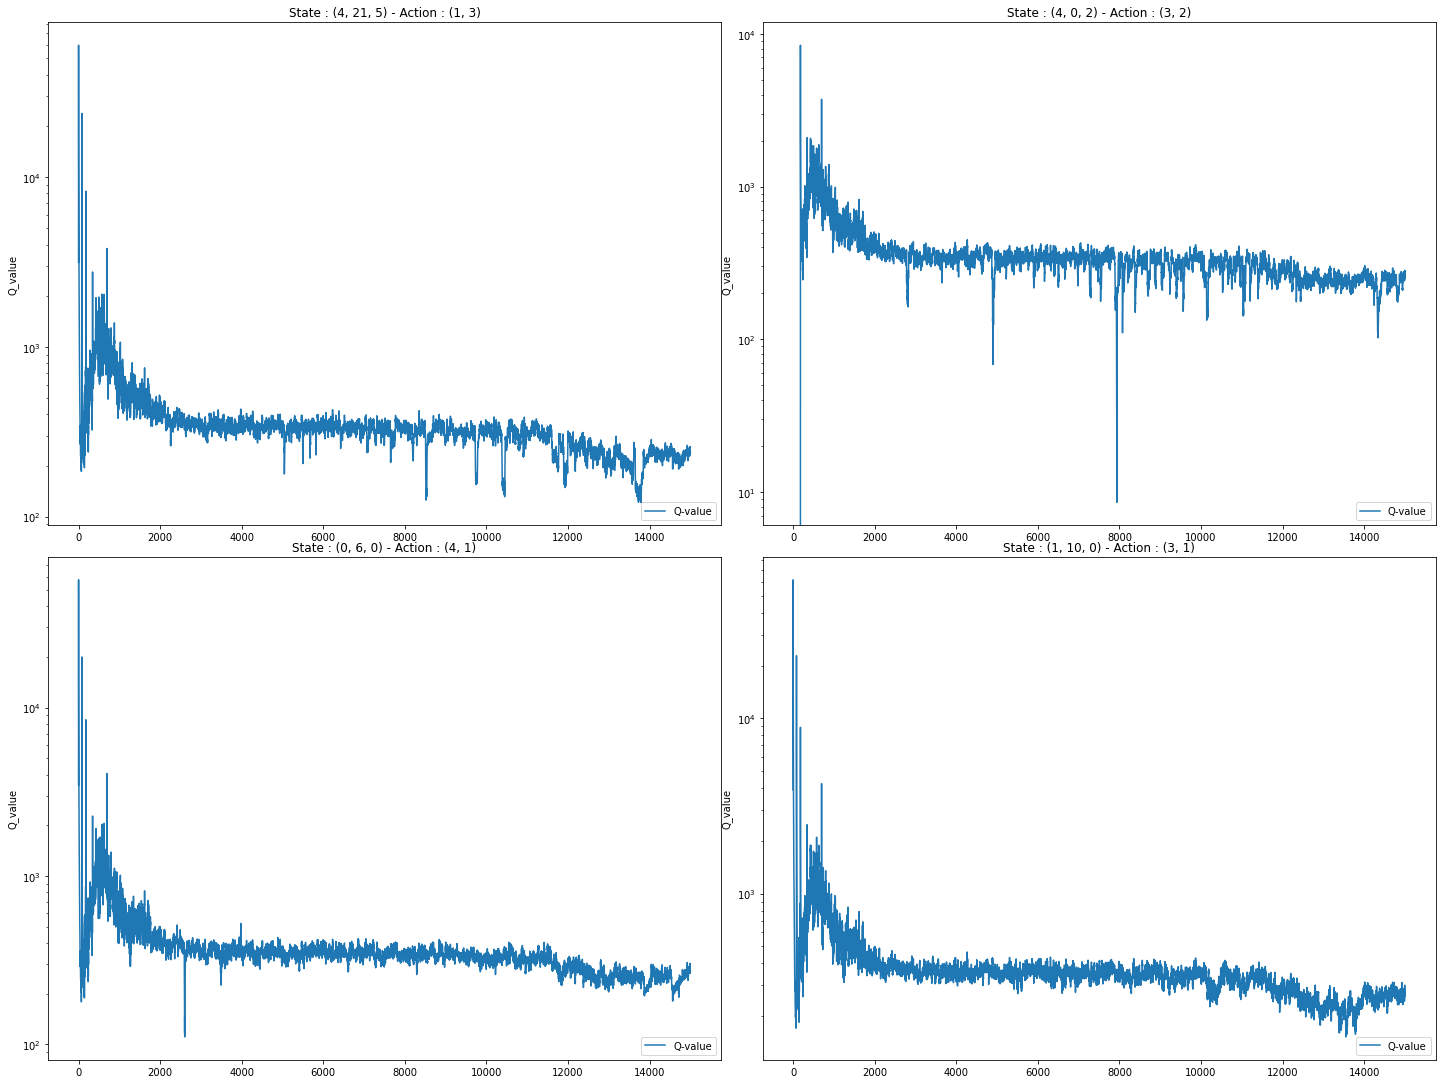

In [16]:
plt.figure(0, figsize=(20, 15))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
fig.tight_layout()

subplots = [i for i in range(221, 225)]

i = 0

for state, action in tracked_states_plotting:
    if i < 4:
        plt.subplot(subplots[i])
        log_convergence_graph_plot(state, action)
        i +=1

plt.show()

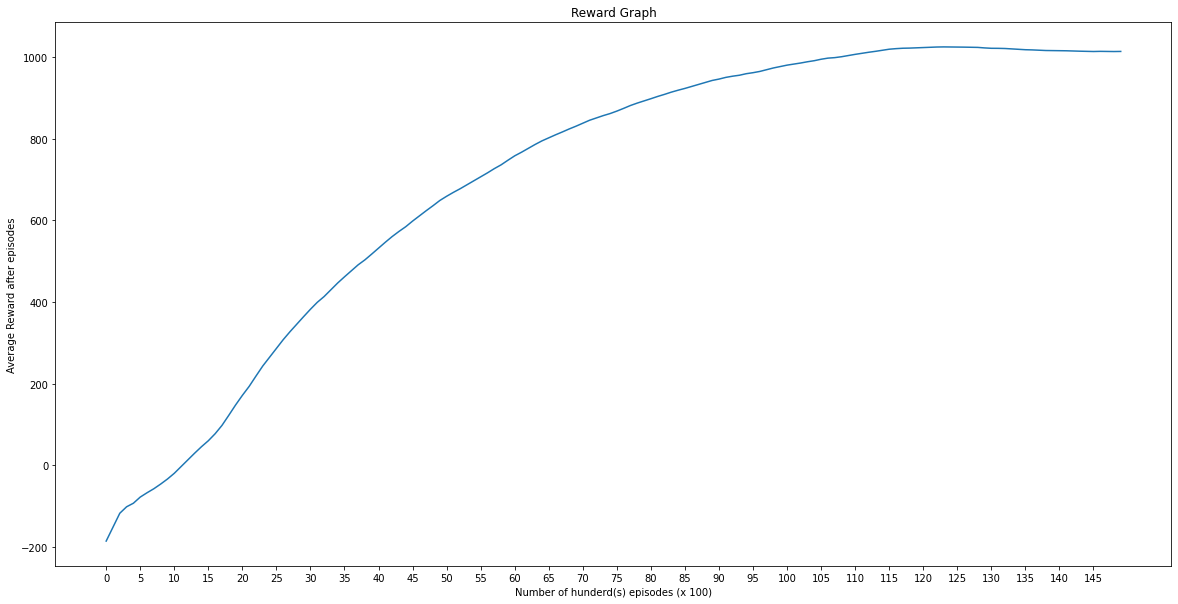

In [17]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 99])
    for x in range(0, 15000, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hunderd(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()